<a href="https://colab.research.google.com/github/borankilic/fake-news-detection/blob/main/fake_news_detection_train%26eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NEUROMATCH 2024 - NATURAL LANGUAGE PROCESSING
# A Novel Approach For Detecting Fake News using Deep Learning Methods

### Pod: Tranquil Kolwitzia / Project Group 1

- **Boran Aybak Kilic**
- Zeinab Jalilzadeh
- Ali Khezri



In this notebook we propose 3 (embedding,model) pairs to classify a news article as either real or fake.

1. Glove Embeddings + LSTM (both uni/bidirectional models)
2. TFIDF + Logistic Regression
2. CountVectorizer() + Logistic Regression
3. pretrained tokenizer + transformer model from BERT



In [ ]:
# @title Import Required Libraries
# We import some libraries to load the dataset
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchtext.vocab import vocab
from collections import Counter, OrderedDict

import torchtext; torchtext.disable_torchtext_deprecation_warning()
from torchtext.data import get_tokenizer

from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
## SET DEVICE
def set_device():
  global device
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
          "if possible, in the menu under `Runtime` -> "
          "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device
set_device()

GPU is enabled in this notebook.


'cuda'

In [ ]:
# @title Import the Dataset
# @markdown You should either import the preprocessed data ('news_df_processed.csv') or the raw dataframe that is of the form {'label' : (0 or 1) , 'content' : (article string)}
news_df_processed = pd.read_csv('news_df_processed.csv')
news_df_processed.tail()

,label,content
44893,0,fully committed nato backs new us approach on ...
44894,0,lexisnexis withdrew two products from chinese ...
44895,0,minsk cultural hub becomes haven from authorit...
44896,0,vatican upbeat on possibility of pope francis ...
44897,0,indonesia to buy dollar billion worth of russ...


In [ ]:
# @title Split the data into text and train datasets
X = news_df_processed.content
y = news_df_processed.label
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Glove Vectorizer + LSTM

In [ ]:
# @title Importing GloVe
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2024-07-25 10:06:17--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-07-25 10:06:17--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-07-25 10:06:18--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
# @title Load the GloVe embeddings into a dictionary
def load_glove_embeddings(dimension=100):
    """
    Load GloVe embeddings from a file and return a dictionary.

    Parameters:
    - dimensions (int): Dimension of the GloVe embeddings. Avaliable options are : 50, 100, 200, 300.
    Returns:
    - embeddings_index (dict): A dictionary mapping words to their GloVe vectors.
    """
    embeddings_index = {}
    if not dimension in [50, 100, 200, 300]:
      print("Invalid dimension. Avaliable options are : 50, 100, 200, 300\n100 is used as default")
      dimension = 100

    glove_file = f'glove.6B.{dimension}d.txt'

    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    print(f"Found {len(embeddings_index)} word vectors.")
    embeddings_index['PAD'] = np.zeros(dimension)
    embeddings_index['UNK'] = np.random.normal(scale=0.6, size=(dimension))
    return embeddings_index


# Load the GloVe embeddings
embeddings_index = load_glove_embeddings(100)


Found 400000 word vectors.


In [ ]:
word_to_idx = {}
idx_to_word = {}
idx_to_embedding = {}
idx_to_word[0] = 'PAD'
idx_to_word[1] = 'UNK'
word_to_idx['PAD'] = 0
word_to_idx['UNK'] = 1

for ii, word in enumerate(list(embeddings_index.keys())):
  word_to_idx[word] = ii + 2
  idx_to_word[ii + 2] = word

for key, value in idx_to_word.items():
  idx_to_embedding[key] = embeddings_index[value]



In [ ]:
# @title Creating a function to generate the embedding matrix

def convert_to_idx(tokenized_text, embeddings_index, word_to_idx):
    articles = []
    for article in tqdm(tokenized_text):
      words= []
      for word in article:
          # If word is in the Glove's dictionary append it to word_embeddings
        if word in embeddings_index:
          words.append(word_to_idx[word])
        else:
          # Assign a random vector to unknown words
          words.append(1)
      articles.append(words)

    return articles

In [ ]:
# @title Padding the articles
# Prepadding is used meaning zeros are inserted at the front of the words
# Note that the output is a Numpy matrix
def padding(sentences, max_len, embeddings_index):
  if max_len == 'none':
    seq_len = max([len(article) for article in sentences])
  else:
    seq_len = max_len
  features = np.zeros((len(sentences), seq_len), dtype=int)
  for ii, article in tqdm(enumerate(sentences)):
    len_article = len(article)
    if len_article != 0:
      # If its shorter, we fill with 0 (the padding Token index)
      if len_article <= seq_len:
        # If its shorter, we fill with zeros (the padding Token index)
        features[ii, -len(article):] = np.array(article)[:seq_len]
      if len_article > seq_len:
        # If its larger, we take the last 'seq_len' indexes
        features[ii, :] = np.array(article)[:seq_len]



  return torch.from_numpy(features)

In [ ]:
# @title NLTK Tokenization Library
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

x_train_nltk = (x_train.apply(lambda x: word_tokenize(x))).to_numpy()
x_test_nltk = (x_test.apply(lambda x: word_tokenize(x))).to_numpy()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Creating The Padded Embedded Matrix

In [ ]:
x_train_tokens = convert_to_idx(x_train_nltk, embeddings_index, word_to_idx)
x_train_tokens= padding(x_train_tokens, 200, embeddings_index)




  0%|          | 0/35918 [00:00<?, ?it/s]

0it [00:00, ?it/s]

In [ ]:
x_test_tokens = convert_to_idx(x_test_nltk, embeddings_index, word_to_idx)
x_test_tokens= padding(x_test_tokens, 200, embeddings_index)


  0%|          | 0/8980 [00:00<?, ?it/s]

0it [00:00, ?it/s]

In [ ]:
for idx in x_train_tokens[0]:
  print(idx_to_word[int(idx)])

france
invites
us
to
dec
summit
on
boosting
fight
against
UNK
militants
accra
reuters
french
president
emmanuel
macron
fears
islamist
militants
have
scored
military
and
symbolic
victories
in
west
africa
while
a
regional
military
force
has
struggled
to
get
off
the
ground
a
french
presidential
source
said
on
thursday
to
help
get
the
new
g
sahel
force
operating
effectively
he
said
france
has
invited
the
united
states
to
a
summit
with
the
five
participating
countries
as
well
as
the
african
union
and
european
union
in
paris
next
month
thousands
of
un
peacekeepers
french
troops
and
us
military
trainers
and
drone
operators
have
failed
so
far
to
stem
a
growing
wave
of
jihadist
violence
leading
world
powers
to
pin
their
hopes
on
the
new
g
sahel
force
the
g
sahel
initiative
grouping
burkina
faso
chad
mali
mauritania
and
niger
faces
an
immense
security
challenge
in
a
largely
desert
and
weakly
governed
region
and
already
faces
questions
over
its
financing
and
provision
of
equipment
emmanuel
macron

In [ ]:
x_train_embeddings = torch.zeros((x_train_tokens.shape[0], x_train_tokens.shape[1] ,100), dtype=torch.float32)
for ii, article in tqdm(enumerate(x_train_tokens)):
  for jj, word in enumerate(article):
    x_train_embeddings[ii,jj,:] = torch.tensor(idx_to_embedding[int(word)], dtype=torch.float32)

0it [00:00, ?it/s]

In [ ]:
x_test_embeddings = torch.zeros((x_test_tokens.shape[0], x_train_tokens.shape[1] ,100), dtype=torch.float32)
for ii, article in tqdm(enumerate(x_test_tokens)):
  for jj, word in enumerate(article):
    x_test_embeddings[ii,jj,:] = torch.tensor(idx_to_embedding[int(word)], dtype=torch.float32)

0it [00:00, ?it/s]

In [ ]:
# create Tensor datasets
train_data = TensorDataset(x_train_embeddings, torch.from_numpy(y_train.to_numpy()))
valid_data = TensorDataset(x_test_embeddings, torch.from_numpy(y_test.to_numpy()))

# Batch size (this is an important hyperparameter)
batch_size = 64

# dataloaders
# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size,drop_last = True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size,drop_last = True)

In [ ]:
# Obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.__next__()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)


Sample input size:  torch.Size([64, 200, 100])
Sample input: 
 tensor([[[-0.4441,  0.5919,  0.9847,  ...,  0.2637,  0.3931,  0.5878],
         [-0.0720,  0.2313,  0.0237,  ..., -0.7189,  0.8689,  0.1954],
         [ 0.5429,  0.4893, -0.0481,  ...,  0.4940,  0.8670,  0.2239],
         ...,
         [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
         [-0.0033,  0.3895,  0.2635,  ..., -0.5945,  1.2107,  0.0016],
         [-0.3000,  0.4412, -0.5226,  ...,  0.3110,  1.0487, -0.2582]],

        [[ 0.4344,  0.8012,  0.2133,  ..., -0.2124, -0.9478, -0.0293],
         [ 0.3365,  0.5383,  0.5897,  ...,  0.5433,  0.0942, -0.4325],
         [ 0.1084, -0.0913, -0.1716,  ..., -0.2291, -0.4122, -0.4313],
         ...,
         [-1.0637,  0.5611, -0.2084,  ..., -0.6899, -0.4967, -1.2453],
         [ 0.6218,  0.6875, -1.3993,  ...,  0.3602, -0.3340,  0.7088],
         [-0.0933,  0.1904,  0.6846,  ..., -0.6817,  0.2880,  0.5489]],

        [[-0.5497, -0.4883,  0.5913,  ..., -0.8608, -

## LSTM

In [ ]:
class News_LSTM(nn.Module):
  def __init__(self, no_layers, hidden_dim, embedding_dim, output_dim, drop_prob=0.1, bidirectional=False):
    super(News_LSTM,self).__init__()

    self.output_dim = output_dim
    self.hidden_dim = hidden_dim
    self.embedding_dim = embedding_dim
    self.no_layers = no_layers
    self.drop_prob = drop_prob
    self.bidirectional = bidirectional




    # LSTM Layers
    self.lstm = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.hidden_dim,
                        num_layers=self.no_layers, batch_first=True,
                        dropout=self.drop_prob, bidirectional = self.bidirectional)

    # Dropout layer
    self.dropout = nn.Dropout(drop_prob)

    # Linear and Sigmoid layer
    if self.bidirectional:
      self.fc = nn.Linear(self.hidden_dim*2, output_dim)
    else:
      self.fc = nn.Linear(self.hidden_dim, output_dim)
    self.sig = nn.Sigmoid()

  def forward(self,x,hidden):

    #embedding_matrix = torch.zeros((x.shape[0], x.shape[1] ,100), dtype=torch.float32)
    #for ii, article in enumerate(x):
    #  for jj, word in enumerate(article):
    #    embedding_matrix[ii,jj,:] = torch.tensor(idx_to_embedding[int(word)], dtype=torch.float32)



    #x = embedding_matrix.to(device)
    # Shape of x: [batch_size, seq_length]
    batch_size = x.size(0)

    # Embedding out
    #embeds = self.embedding(x)
    #Shape: [batch_size x max_length x embedding_dim]

    # LSTM out
    lstm_out, hidden = self.lstm(x, hidden)
    # Shape: [batch_size x max_length x hidden_dim]

    # Select the activation of the last Hidden Layer
    lstm_out = lstm_out[:,-1,:].contiguous()
    # Shape: [batch_size x hidden_dim]

    ## You can instead average the activations across all the times
    # lstm_out = torch.mean(lstm_out, 1).contiguous()

    # Dropout and Fully connected layer
    out = self.dropout(lstm_out)
    out = self.fc(out)

    # Sigmoid function
    sig_out = self.sig(out)

    # return last sigmoid output and hidden state
    return sig_out, hidden

  def init_hidden(self, batch_size):
    ''' Initializes hidden state '''
    # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
    # initialized to zero, for hidden state and cell state of LSTM
    if self.bidirectional:
      h0 = torch.zeros((self.no_layers*2,batch_size,self.hidden_dim)).to(device)
      c0 = torch.zeros((self.no_layers*2,batch_size,self.hidden_dim)).to(device)
    else:
      h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
      c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
    hidden = (h0,c0)
    return hidden

In [ ]:
# @title Instanciate the Model

# Parameters of our network

# Embedding dimension
embedding_dim = 100

# Number of stacked LSTM layers
no_layers = 2

# Dimension of the hidden layer in LSTMs
hidden_dim = 128

# Dropout parameter for regularization
output_dim = 1

# Dropout parameter for regularization
drop_prob = 0.1

# Let's define our model

uni_lstm = News_LSTM(no_layers, hidden_dim,
                     embedding_dim,output_dim, drop_prob, bidirectional=False)


# Moving to gpu
uni_lstm.to(device)
print(uni_lstm)

News_LSTM(
  (lstm): LSTM(100, 128, num_layers=2, batch_first=True, dropout=0.1)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [ ]:
# How many trainable parameters does our model have?
model_parameters = filter(lambda p: p.requires_grad, uni_lstm.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print('Total Number of parameters: ',params)

Total Number of parameters:  249985


In [ ]:
# @title Define Hyperparameters

# loss and optimization functions
lr = 0.01

# Binary crossentropy is a good loss function for a binary classification problem
criterion = nn.BCELoss()

# We choose an Adam optimizer
optimizer = torch.optim.Adam(uni_lstm.parameters(), lr=lr)

# Set up scheduler
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

# Number of training Epochs
epochs = 20

# Maximum absolute value accepted for the gradeint
clip = 50



In [ ]:
# @title Training and Test Loops

# function to predict accuracy
def acc(pred,label):
  pred = torch.round(pred.squeeze())
  return torch.sum(pred == label.squeeze()).item()


# Train for a number of Epochs
def train_LSTM_model(model, train_loader, valid_loader, epochs, clip, criterion, optimizer, scheduler=None, device = device ):
  # Initial Loss value (assumed big)
  valid_loss_min = np.inf

  # Lists to follow the evolution of the loss and accuracy
  epoch_tr_loss,epoch_vl_loss = [],[]
  epoch_tr_acc,epoch_vl_acc = [],[]

  # Train for a number of Epochs
  for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()

    for inputs, labels in train_loader:

      # Initialize hidden state
      h = model.init_hidden(batch_size)
      # Creating new variables for the hidden state
      h = tuple([each.data.to(device) for each in h])

      # Move batch inputs and labels to gpu
      inputs, labels = inputs.to(device), labels.to(device)


      # Zero out the gradient


      # Set gradient to zero
      model.zero_grad()

      # Compute model output
      output,h = model(inputs,h)

      # Calculate the loss and perform backprop
      loss = criterion(output.squeeze(), labels.float())
      #loss.requires_grad = True
      loss.backward()
      train_losses.append(loss.item())

      # calculating accuracy
      accuracy = acc(output,labels)
      train_acc += accuracy

      #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
      nn.utils.clip_grad_norm_(model.parameters(), clip)
      optimizer.step()

    # step the scheduler
    if scheduler:
      scheduler.step()


    # Evaluate on the validation set for this epoch
    labels_lst = []
    preds_lst = []
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:

      # Initialize hidden state
      val_h = model.init_hidden(batch_size)
      val_h = tuple([each.data.to(device) for each in val_h])

      # Move batch inputs and labels to gpu
      inputs, labels = inputs.to(device), labels.to(device)

      # Compute model output
      output, val_h = model(inputs, val_h)

      # Compute Loss
      val_loss = criterion(output.squeeze(), labels.float())

      pred = torch.round(output.squeeze())
      preds_lst.append(pred)
      labels_lst.append(labels)
      # Calculate Accuracy
      val_losses.append(val_loss.item())

      accuracy = acc(output,labels)
      val_acc += accuracy

    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}')
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
      print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
      # torch.save(model.state_dict(), '../working/state_dict.pt')
      valid_loss_min = epoch_val_loss
    print(25*'==')
  return epoch_tr_acc, epoch_vl_acc, epoch_tr_loss, epoch_vl_loss, preds_lst, labels_lst

def plot_loss_acc(epoch_tr_acc, epoch_vl_acc, epoch_tr_loss, epoch_vl_loss):
  fig = plt.figure(figsize = (20, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epoch_tr_acc, label='Train Acc')
  plt.plot(epoch_vl_acc, label='Validation Acc')
  plt.title("Accuracy")
  plt.legend()
  plt.grid()

  plt.subplot(1, 2, 2)
  plt.plot(epoch_tr_loss, label='Train loss')
  plt.plot(epoch_vl_loss, label='Validation loss')
  plt.title("Loss")
  plt.legend()
  plt.grid()

  plt.show()

def confusion_mat(color, y_test, pred):
    cof=confusion_matrix(y_test, pred)
    cof=pd.DataFrame(cof, index=[i for i in range(1,3)], columns=[i for i in range(1,3)])
    sns.set(font_scale=1.5)
    plt.figure(figsize=(8,8));

    sns.heatmap(cof, cmap=color,linewidths=1, annot=True,square=True, fmt='d', cbar=False,xticklabels=['True','False'],yticklabels=['True','False']);
    plt.xlabel("Predicted Classes");
    plt.ylabel("Actual Classes");


#confusion_mat('YlGn',y_test,pred)

In [ ]:
def eval_model(model, val_loader, device):

  batch_size = len(next(iter(val_loader))[0])
  # Evaluate on the validation set for this epoch
  labels_lst = []
  preds_lst = []
  val_losses = []
  val_acc = 0.0
  model.eval()
  for inputs, labels in val_loader:

    # Initialize hidden state
    val_h = model.init_hidden(batch_size)
    val_h = tuple([each.data.to(device) for each in val_h])

    # Move batch inputs and labels to gpu
    inputs, labels = inputs.to(device), labels.to(device)

    # Compute model output
    output, val_h = model(inputs, val_h)

    # Compute Loss
    val_loss = criterion(output.squeeze(), labels.float())

    pred = torch.round(output.squeeze())
    preds_lst.append(pred)
    labels_lst.append(labels)
    # Calculate Accuracy
    val_losses.append(val_loss.item())

    accuracy = acc(output,labels)
    val_acc += accuracy

  return labels_lst, preds_lst, val_losses, val_acc


Epoch 1
train_loss : 0.21477739630705295 val_loss : 0.022784842218139343
train_accuracy : 89.87415780388663 val_accuracy : 99.32071269487751
Validation loss decreased (inf --> 0.022785).  Saving model ...
Epoch 2
train_loss : 0.018272546468507633 val_loss : 0.009116796961253774
train_accuracy : 99.59351857007628 val_accuracy : 99.61024498886414
Validation loss decreased (0.022785 --> 0.009117).  Saving model ...
Epoch 3
train_loss : 0.010123883326099637 val_loss : 0.007494639245643546
train_accuracy : 99.72437218107912 val_accuracy : 99.6325167037862
Validation loss decreased (0.009117 --> 0.007495).  Saving model ...
Epoch 4
train_loss : 0.011891743434838363 val_loss : 0.017312833831445978
train_accuracy : 99.65476919650314 val_accuracy : 99.42093541202672
Epoch 5
train_loss : 0.01216691873526473 val_loss : 0.00733974958088116
train_accuracy : 99.70209922601481 val_accuracy : 99.62138084632517
Validation loss decreased (0.007495 --> 0.007340).  Saving model ...
Epoch 6
train_loss : 0.

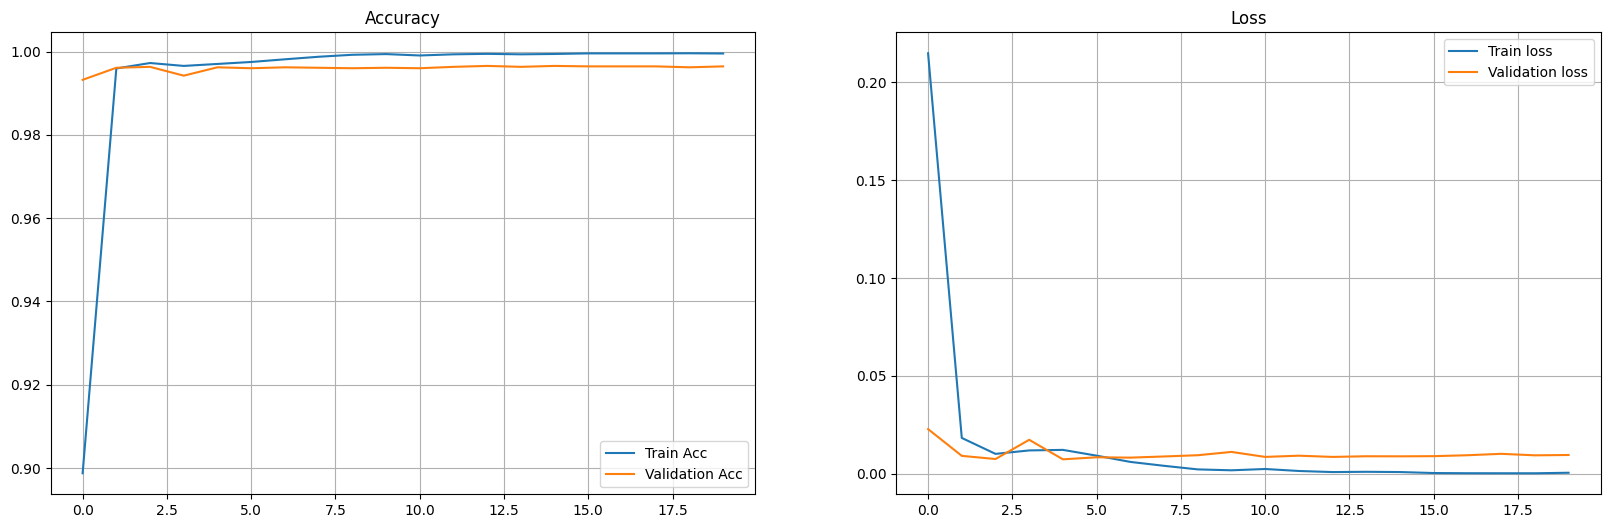

In [ ]:
# @title Unidirectional LSTM
epoch_tr_acc, epoch_vl_acc, epoch_tr_loss, epoch_vl_loss , y_preds , y_labels= train_LSTM_model(uni_lstm, train_loader, valid_loader, epochs, clip, criterion, optimizer,scheduler,  device=device)
plot_loss_acc(epoch_tr_acc, epoch_vl_acc, epoch_tr_loss, epoch_vl_loss)

In [ ]:

y_preds = torch.cat(y_preds)
y_labels = torch.cat(y_labels)
y_preds = y_preds.detach().cpu().numpy()
y_labels = y_labels.detach().cpu().numpy()
print('\nClassification Report For uni_lstm\n')
print(classification_report(y_labels, y_preds, digits=4))



Classification Report For uni_lstm

              precision    recall  f1-score   support

           0     0.9993    0.9979    0.9986      4273
           1     0.9981    0.9994    0.9987      4687

    accuracy                         0.9987      8960
   macro avg     0.9987    0.9986    0.9987      8960
weighted avg     0.9987    0.9987    0.9987      8960



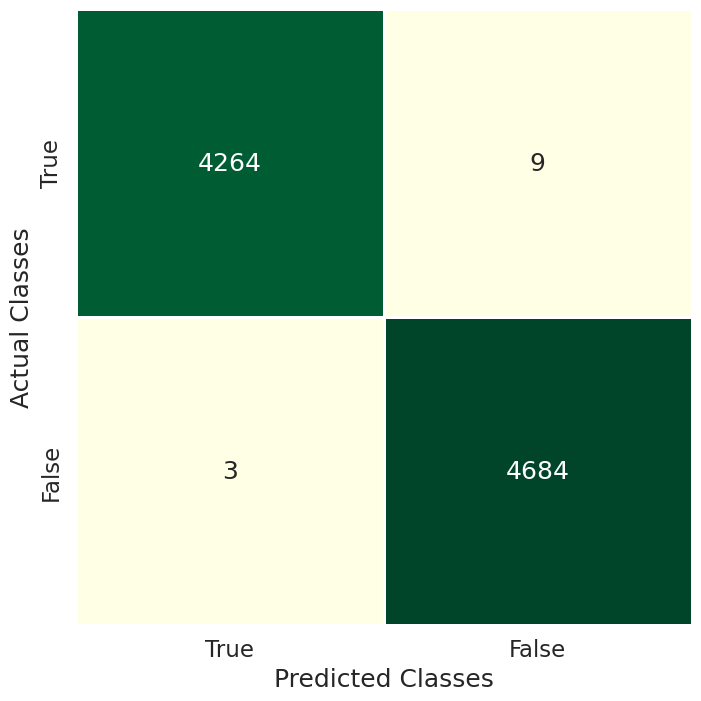

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_mat('YlGn',y_labels,y_preds)

In [ ]:
# @title Bidirectional LSTM Model
bi_lstm = News_LSTM(no_layers, hidden_dim,
                     embedding_dim,output_dim, drop_prob, bidirectional=True)
bi_lstm.to(device)
print(bi_lstm)

News_LSTM(
  (lstm): LSTM(100, 128, num_layers=2, batch_first=True, dropout=0.1, bidirectional=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


Epoch 1
train_loss : 0.18118014952222652 val_loss : 0.019025350608197707
train_accuracy : 92.41884291998441 val_accuracy : 99.28730512249443
Validation loss decreased (inf --> 0.019025).  Saving model ...
Epoch 2
train_loss : 0.014919966131557898 val_loss : 0.00789164697240007
train_accuracy : 99.62692800267276 val_accuracy : 99.62138084632517
Validation loss decreased (0.019025 --> 0.007892).  Saving model ...
Epoch 3
train_loss : 0.013013849651118086 val_loss : 0.009207814869919924
train_accuracy : 99.65755331588618 val_accuracy : 99.61024498886414
Epoch 4
train_loss : 0.03543903920196666 val_loss : 0.014703858332982886
train_accuracy : 98.85015869480483 val_accuracy : 99.51002227171493
Epoch 5
train_loss : 0.014003452300271493 val_loss : 0.021367096341314857
train_accuracy : 99.63806448020492 val_accuracy : 99.39866369710467
Epoch 6
train_loss : 0.009478815586818507 val_loss : 0.009487792563595577
train_accuracy : 99.72437218107912 val_accuracy : 99.57683741648107
Epoch 7
train_loss

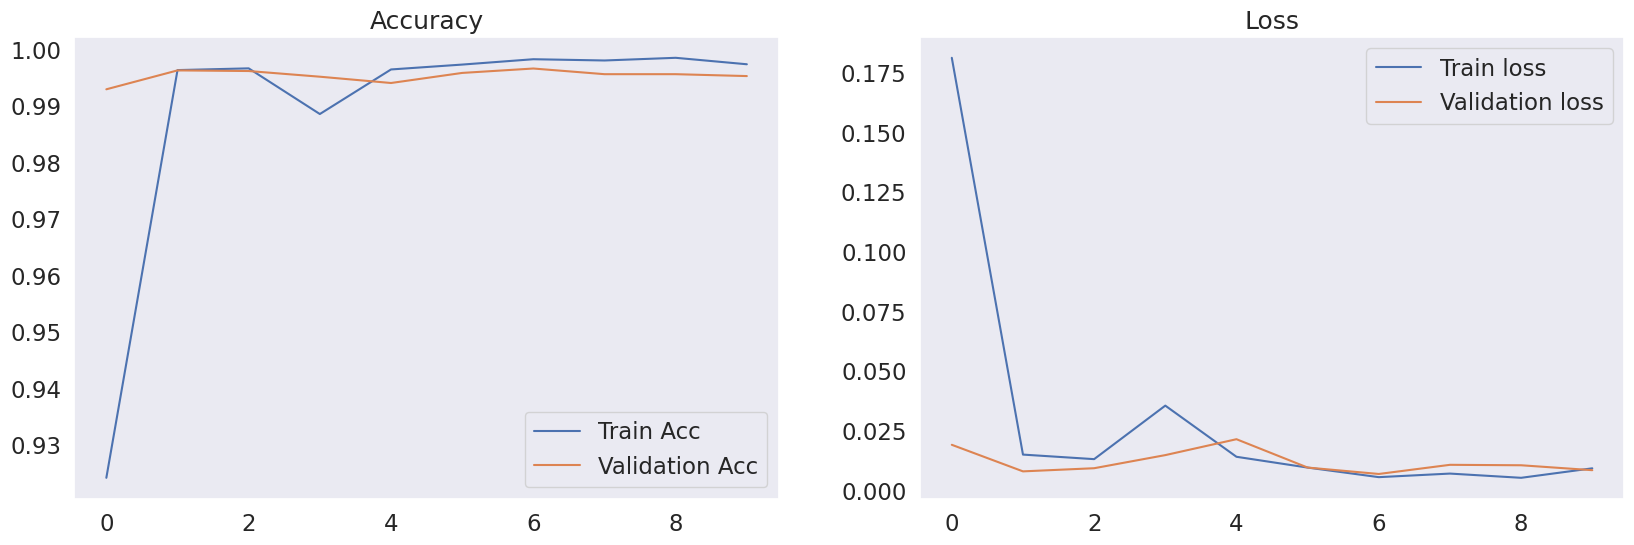

In [ ]:
epoch_tr_acc, epoch_vl_acc, epoch_tr_loss, epoch_vl_loss , y_preds , y_labels= train_LSTM_model(bi_lstm, train_loader, valid_loader, 10, clip, criterion, torch.optim.Adam(bi_lstm.parameters(), lr=lr),scheduler,  device=device)
plot_loss_acc(epoch_tr_acc, epoch_vl_acc, epoch_tr_loss, epoch_vl_loss)

In [ ]:
y_preds = torch.cat(y_preds)
y_labels = torch.cat(y_labels)
y_preds = y_preds.detach().cpu().numpy()
y_labels = y_labels.detach().cpu().numpy()
print('\nClassification Report For bi_lstm\n')
print(classification_report(y_labels, y_preds, digits=4))


Classification Report For bi_lstm

              precision    recall  f1-score   support

           0     0.9963    0.9984    0.9973      4274
           1     0.9985    0.9966    0.9975      4686

    accuracy                         0.9974      8960
   macro avg     0.9974    0.9975    0.9974      8960
weighted avg     0.9974    0.9974    0.9974      8960



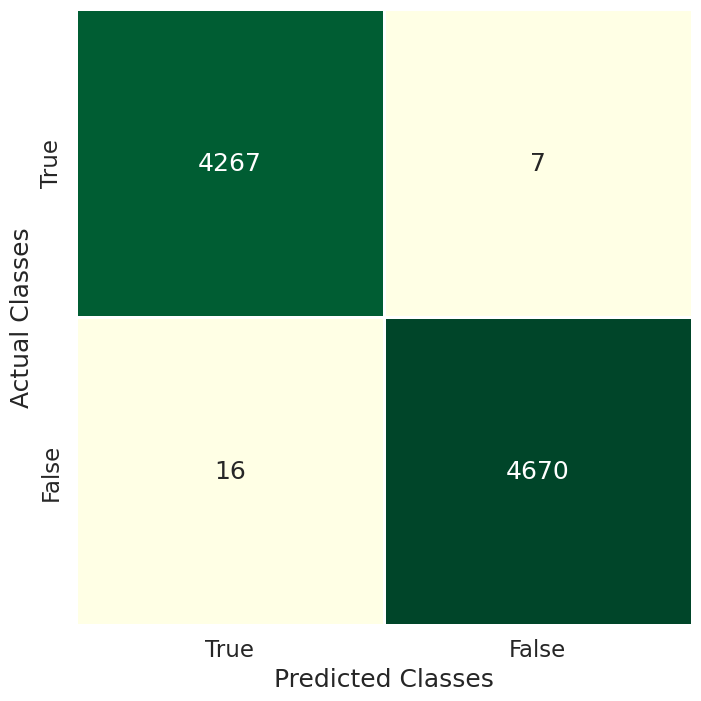

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_mat('YlGn',y_labels,y_preds)

In [ ]:
# @title Save and Load Models
def save_model(model, path):
  '''Function to save the model
  Args:
    model(nn.Module): Pretrained model that you want the save the parameters of.
    path(str): Path to save the model
  '''

  torch.save(model.state_dict(), path)

def load_model(model_class, path, eval = False):
  '''Function to save the model
  Args:
    model(nn.Module): Model class that you've created.
    path(str): Path of the file containing model weights.
  Returns:
    model(nn.Module): Instance of the model class with the weights loaded.
  '''

  model = model_class()
  model.load_state_dict(torch.load(path))
  if eval:
    model.eval()
  return model


In [ ]:
save_model(bi_lstm, 'bi_lstm_maxword200_embed100.pt')

NameError: name 'bi_lstm' is not defined

# TF-IDF

In [ ]:
import string
from sklearn.feature_extraction.text import CountVectorizer # Bag of words
from sklearn.feature_extraction.text import TfidfVectorizer # Tfid
from sklearn.metrics import classification_report

## TF-IDF Vectorizer

TF-IDF Vectorizer from the sklearn library vectorizes the words based on their frequency and hence relative importance in the text. For more on that click  <a href='https://www.learndatasci.com/glossary/tf-idf-term-frequency-inverse-document-frequency/#:~:text=cost%20to%20you.-,What%20is%20TF%2DIDF%3F,%2C%20relative%20to%20a%20corpus).'>here </a>.

In [ ]:
vectorizer_tf = TfidfVectorizer(tokenizer=None,stop_words=None,max_df=0.75,max_features=2000,lowercase=False,ngram_range=(1,2))
train_vectors = vectorizer_tf.fit_transform(x_train)
test_vectors = vectorizer_tf.transform(x_test)
test_vectors


<8980x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 1463336 stored elements in Compressed Sparse Row format>

In [ ]:
test_df = pd.DataFrame(test_vectors.toarray(),columns=vectorizer_tf.get_feature_names_out())
test_df = pd.concat([test_df,y_test.reset_index(drop = True)],axis = 1)

test_df

,ability,able,able to,abortion,about,about his,about how,about the,absolutely,accept,...,york times,you,you are,you can,you have,you know,you re,young,your,label
0,0.0,0.000000,0.000000,0.0,0.048573,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.030649,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,1
1,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0
2,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0
3,0.0,0.000000,0.000000,0.0,0.023355,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0
4,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.028862,0.0,0.0,0.057882,0.000000,0.0,0.106387,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8975,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.069749,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.051579,1
8976,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,1
8977,0.0,0.048598,0.048822,0.0,0.091387,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.057664,0.0,0.0,0.000000,0.057297,0.0,0.000000,0.042771,1
8978,0.0,0.000000,0.000000,0.0,0.017354,0.0,0.0,0.028875,0.000000,0.0,...,0.0,0.021901,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,1


## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import seaborn as sns

In [ ]:
lr_model = LogisticRegression(penalty='l2',solver= 'newton-cg',multi_class= 'multinomial')
# L2 = L2 regularization helps to overcome (overfitting vs underfitting)
# solver = newton-cg ... For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss; ‘liblinear’ is limited to one-versus-rest schemes.
lr_model.fit(train_vectors,y_train)
pred = lr_model.predict(test_vectors)

In [ ]:
print("first 20 actual labels")
print(y_test.tolist()[:20])
print("first 20 predicted labels")
print(pred.tolist()[:20])

first 20 actual labels
[1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1]
first 20 predicted labels
[1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1]


## Display Results

In [ ]:
print('\nClassification Report\n')
print(classification_report(y_test,pred, digits=4))


Classification Report

              precision    recall  f1-score   support

           0     0.9921    0.9942    0.9931      4284
           1     0.9947    0.9928    0.9937      4696

    accuracy                         0.9934      8980
   macro avg     0.9934    0.9935    0.9934      8980
weighted avg     0.9934    0.9934    0.9934      8980



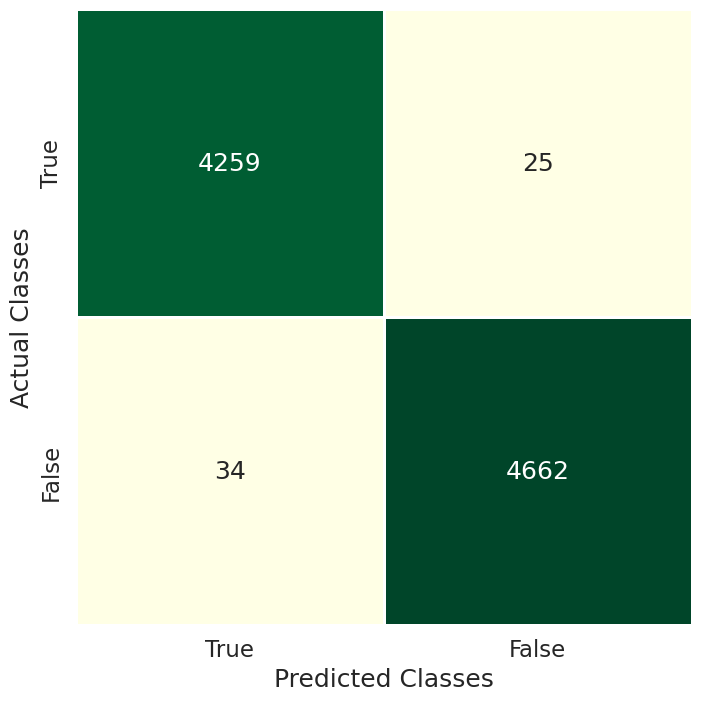

In [ ]:
confusion_mat('YlGn',y_test,pred)

# CountVectorizer()

In [ ]:

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, SpatialDropout1D
from keras.preprocessing.sequence import pad_sequences


In [ ]:
# @title Data Retrieval and Split
data = pd.read_csv('news_df_processed.csv')
data['content'] = data['content'].str.lower()
data['content'] = data['content'].str.replace('[^\w\s]', '')


le = LabelEncoder()
data['label'] = le.fit_transform(data['label'])


X = data['content']
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




#X_train_counts = X_train_counts.toarray()
#X_test_counts = X_test_counts.toarray()


#max_length = 500
#X_train_padded = pad_sequences(X_train_counts, maxlen=max_length)
#X_test_padded = pad_sequences(X_test_counts, maxlen=max_length)




In [ ]:
# @title Vectorizing
count_vectorizer = CountVectorizer(max_features=2000)
X_train_counts = count_vectorizer.fit_transform(X_train)
X_test_counts = count_vectorizer.transform(X_test)

In [ ]:
# @title Fitting the model and Evaulation
lr_model = LogisticRegression(penalty='l2',solver= 'newton-cg',multi_class= 'multinomial')
# L2 = L2 regularization helps to overcome (overfitting vs underfitting)
# solver = newton-cg ... For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss; ‘liblinear’ is limited to one-versus-rest schemes.
lr_model.fit(X_train_counts,y_train)
pred = lr_model.predict(X_test_counts)

In [ ]:
# @title Display Results
print('\nClassification Report\n')
print(classification_report(y_test,pred, digits=4))


Classification Report

              precision    recall  f1-score   support

           0     0.9972    0.9960    0.9966      4247
           1     0.9964    0.9975    0.9969      4733

    accuracy                         0.9968      8980
   macro avg     0.9968    0.9967    0.9968      8980
weighted avg     0.9968    0.9968    0.9968      8980



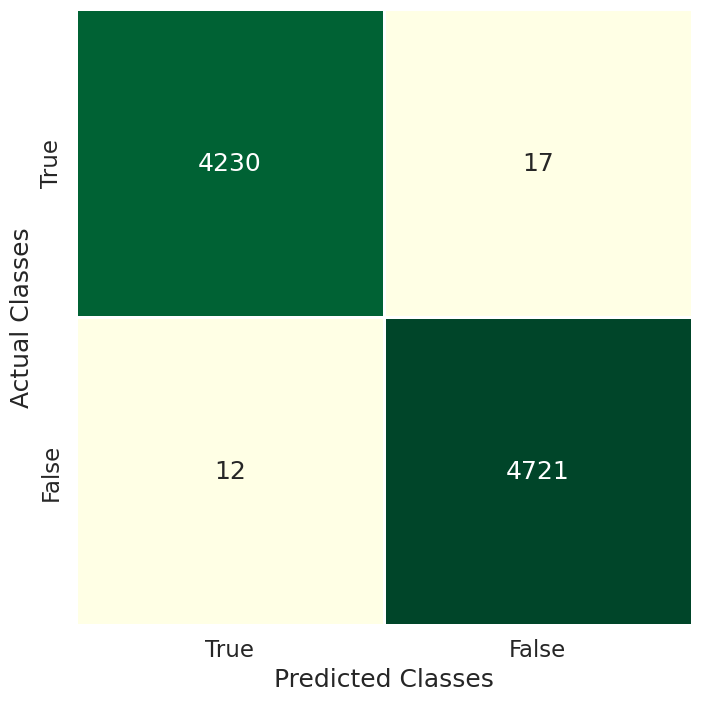

In [ ]:
confusion_mat('YlGn',y_test,pred)

# BERT

In [ ]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.ops.numpy_ops import np_utils
from transformers import BertModel, TFBertModel, BertConfig
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras import regularizers
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from transformers import AutoTokenizer

In [ ]:
# @title Import the base model for BERT and the BERT tokenizer
# @markdown For more information please refer to <a href='https://huggingface.co/google-bert/bert-base-uncased'>Hugging face </a>.
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# @title Import the pretreained model and tokenizer
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
data_text = news_df_processed['content']
data_label = news_df_processed['label']

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(data_text, data_label, stratify = data_label, test_size = 0.2, random_state =42)

In [ ]:
# @title Tokenize the Words
def tokenize(X):

  X = bert_tokenizer(
      text = list(X),
      add_special_tokens = True,
      max_length = 100,
      truncation = True,
      padding = 'max_length',
      return_tensors = 'tf',
      return_token_type_ids = False,
      return_attention_mask = True,
      verbose = True
      )
  return X

In [ ]:
X_train_token = tokenize(X_train)
X_test_token = tokenize(X_test)

 Attention masks identify which words in each article will contribute to classification
 In the case of truncated article we expects some of ids to be zero , meaning there were actually no words there and it's just a placeholder

In [ ]:
X_test_token['attention_mask']

<tf.Tensor: shape=(8980, 100), dtype=int32, numpy=
array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int32)>

In [ ]:
# @title Create a Custom BERT model (initialising from TFBertModel class is unstable)
maxlen = 100
def create_model():
  dropout_rate=0.2
  input_ids=Input(shape=(maxlen,),dtype=tf.int32)
  input_mask=Input(shape=(maxlen,),dtype=tf.int32)
  #bert_layer=bert_model([input_ids,input_mask])[1]
  bert_layer=bert_model(inputs={'input_ids': input_ids, 'attention_mask': input_mask})[1]
  x=Dropout(0.5)(bert_layer)
  x=Dense(64,activation="tanh")(x)
  x=Dropout(0.2)(x)
  x=Dense(1,activation="sigmoid")(x)
  model = Model(inputs=[input_ids, input_mask], outputs=x)
  return model

In [ ]:
import tensorflow as tf
from transformers import TFBertModel

class BertLayer(tf.keras.layers.Layer):
    def __init__(self, bert_model_name, **kwargs):
        super(BertLayer, self).__init__(**kwargs)
        # Load the configuration first
        config = BertConfig.from_pretrained(bert_model_name)
        self.bert = TFBertModel.from_pretrained(bert_model_name, config=config) # Pass the config here

    def call(self, inputs):
        input_ids, attention_mask = inputs
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.pooler_output

def create_model(maxlen=100, bert_model_name='bert-base-uncased'):
    input_ids = tf.keras.layers.Input(shape=(maxlen,), dtype=tf.int32, name='input_ids')
    input_mask = tf.keras.layers.Input(shape=(maxlen,), dtype=tf.int32, name='input_mask')

    bert_layer = BertLayer(bert_model_name)
    bert_output = bert_layer([input_ids, input_mask])

    x = tf.keras.layers.Dropout(0.5)(bert_output)
    x = tf.keras.layers.Dense(64, activation="tanh")(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    output = tf.keras.layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=output)
    return model

# Instantiate and compile the model
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 100)]                0         []                            
                                                                                                  
 input_mask (InputLayer)     [(None, 100)]                0         []                            
                                                                                                  
 bert_layer (BertLayer)      (None, 768)                  1094822   ['input_ids[0][0]',           
                                                          40         'input_mask[0][0]']          
                                                                                                  
 dropout (Dropout)           (None, 768)                  0         ['bert_layer[0][0]']      

In [ ]:
# @title Set up the Hyperparameters and Train the Model
optimizer = Adam(learning_rate=1e-05, epsilon=1e-08,clipnorm=1.0)
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = 'accuracy')

In [ ]:
# Determine early stopping criteria
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='max', verbose=1, patience=50,baseline=0.4,min_delta=0.0001,restore_best_weights=False)

In [ ]:
# @markdown Beware of the fact that training the model for 1 epoch takes approx. 10 minutes on 15.84 GB Tesla T4 GPU
history = model.fit(x = {'input_ids':X_train_token['input_ids'],'input_mask':X_train_token['attention_mask']}, y = Y_train, epochs=2, validation_split = 0.2, batch_size = 30, callbacks=[callback])

NameError: name 'model' is not defined

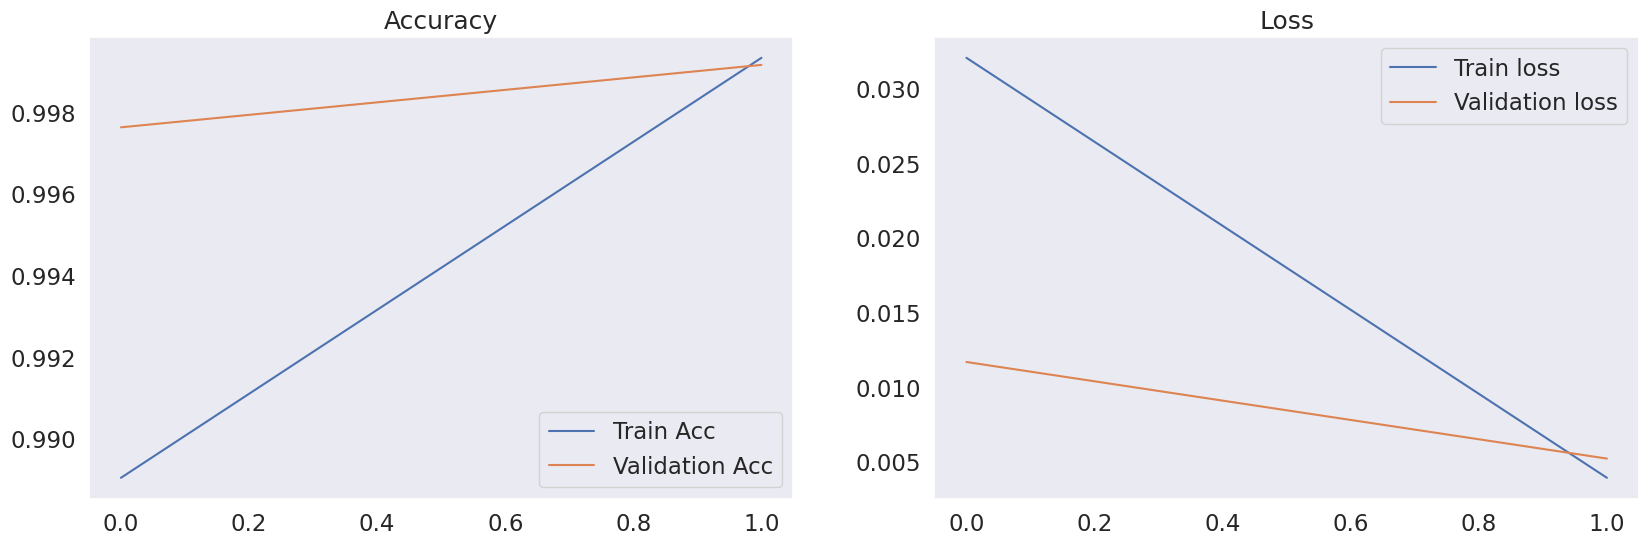

In [ ]:
# @title Display Results
plot_loss_acc(history.history['accuracy'], history.history['val_accuracy'], history.history['loss'], history.history['val_loss'])

In [ ]:
y_pred = np.where(model.predict({ 'input_ids' : X_test_token['input_ids'] , 'input_mask' : X_test_token['attention_mask']}) >=0.5,1,0)

281/281 [==============================] - 75s 220ms/step


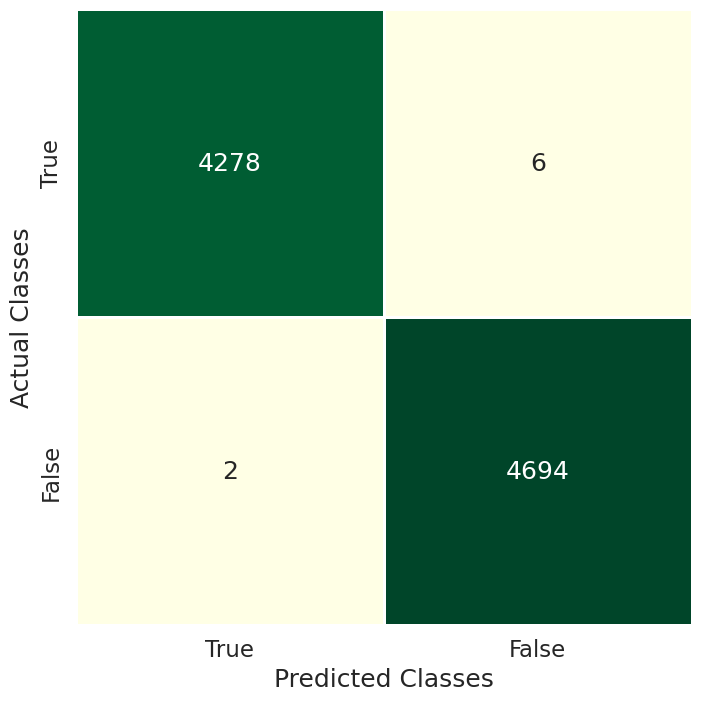

In [ ]:
confusion_mat('YlGn',Y_test,y_pred)

In [ ]:
print(classification_report(Y_test,y_pred,digits=6))

              precision    recall  f1-score   support

           0   0.999533  0.998599  0.999066      4284
           1   0.998723  0.999574  0.999149      4696

    accuracy                       0.999109      8980
   macro avg   0.999128  0.999087  0.999107      8980
weighted avg   0.999109  0.999109  0.999109      8980



In [ ]:
# Assuming 'model' is your instantiated BERT model in TensorFlow
model.save_weights('bert_model_weights.h5')

#Valiation on a different dataset

Since accuracy and f1-scores of our models on this dataset were suspiciously high, we have evaluated or trained models on another dataset.
You need to download the dataset of your choice and transfer into a CSV for this section.

In [ ]:
val_df_processed = pd.read_csv('news_df_valdata2.csv')
val_df_processed.tail()

,label,content
6330,0,state department says it can not find emails f...
6331,1,the p in pbs should stand for plutocratic or p...
6332,1,antitrump protesters are tools of the oligarch...
6333,0,in ethiopia obama seeks progress on peace secu...
6334,0,jeb bush is suddenly attacking trump heres why...


In [ ]:
val_df_processed['Label'] = val_df_processed['Label'].apply(lambda x: 1 - x)

In [ ]:
val_df_processed.label.value_counts()

label
0    3171
1    3164
Name: count, dtype: int64

In [ ]:
val_df_processed.tail()

,Label,content
3983,1,cnn and globalist exposed steve quayle and al...
3984,1,trends to watch trends to watch percent of re...
3985,1,trump jr is soon to give a minute speech for ...
3986,0,china to accept overseas trial data in bid to ...
3987,1,vice president mike pence leaves nfl game beca...


In [ ]:
X = val_df_processed.content
y = val_df_processed.label
_, x_test, _, y_test = train_test_split(X, y, test_size= 0.99 , random_state=42, stratify=y)

In [ ]:
# @title LSTM
x_test_nltk = (x_test.apply(lambda x: word_tokenize(x))).to_numpy()
x_test_tokens = convert_to_idx(x_test_nltk, embeddings_index, word_to_idx)
x_test_tokens= padding(x_test_tokens, 200, embeddings_index)
x_test_embeddings = torch.zeros((x_test_tokens.shape[0], x_train_tokens.shape[1] ,100), dtype=torch.float32)
for ii, article in tqdm(enumerate(x_test_tokens)):
  for jj, word in enumerate(article):
    x_test_embeddings[ii,jj,:] = torch.tensor(idx_to_embedding[int(word)], dtype=torch.float32)

valid_data = TensorDataset(x_test_embeddings, torch.from_numpy(y_test.to_numpy()))

# Batch size (this is an important hyperparameter)
batch_size = 64

# make sure to SHUFFLE your data
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size,drop_last = True)

  0%|          | 0/6272 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
y_labels, y_preds , val_losses, val_acc =  eval_model(uni_lstm, valid_loader, device)

In [ ]:
y_preds = torch.cat(y_preds)
y_labels = torch.cat(y_labels)
y_preds = y_preds.detach().cpu().numpy()
y_labels = y_labels.detach().cpu().numpy()
print('\nClassification Report For uni_lstm\n')
print(classification_report(y_labels, y_preds, digits=4))


Classification Report For uni_lstm

              precision    recall  f1-score   support

           0     0.6074    0.0991    0.1704      3139
           1     0.5090    0.9358    0.6594      3133

    accuracy                         0.5171      6272
   macro avg     0.5582    0.5175    0.4149      6272
weighted avg     0.5583    0.5171    0.4146      6272



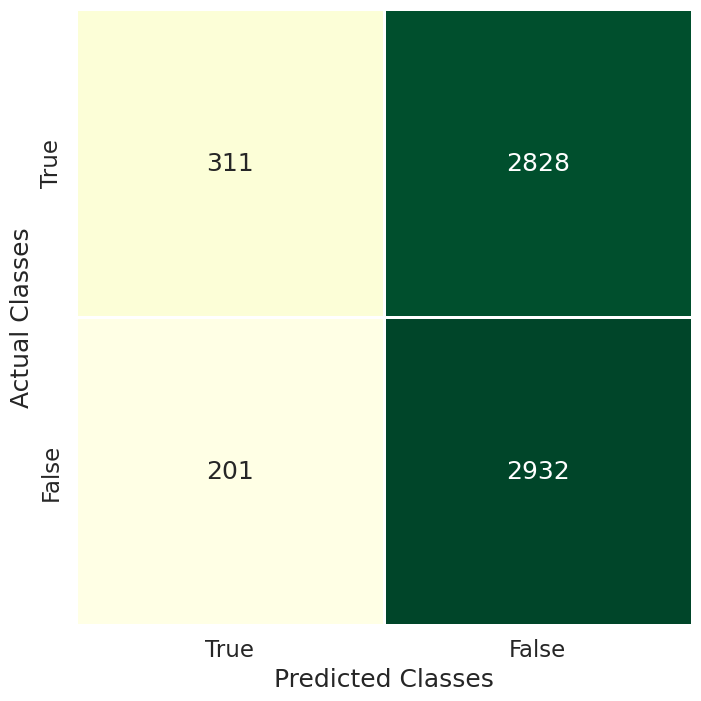

In [ ]:
confusion_mat('YlGn',y_labels,y_preds)

In [ ]:
y_labels, y_preds , val_losses, val_acc =  eval_model(bi_lstm, valid_loader, device)


In [ ]:
y_preds = torch.cat(y_preds)
y_labels = torch.cat(y_labels)
y_preds = y_preds.detach().cpu().numpy()
y_labels = y_labels.detach().cpu().numpy()
print('\nClassification Report For uni_lstm\n')
print(classification_report(y_labels, y_preds, digits=4))


Classification Report For uni_lstm

              precision    recall  f1-score   support

           0     0.6105    0.1373    0.2242      3139
           1     0.5135    0.9122    0.6571      3133

    accuracy                         0.5244      6272
   macro avg     0.5620    0.5248    0.4406      6272
weighted avg     0.5620    0.5244    0.4404      6272



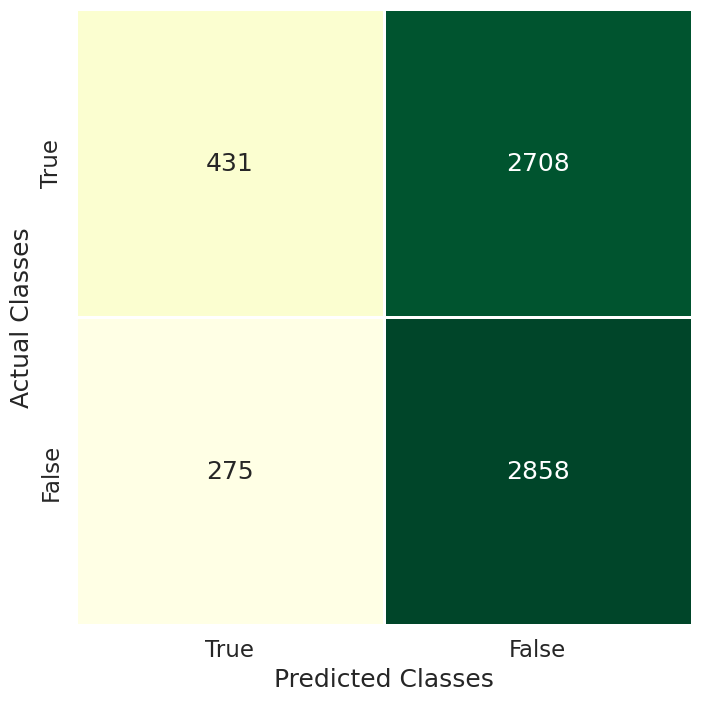

In [ ]:
confusion_mat('YlGn',y_labels,y_preds)

In [ ]:
# @title TFIDF
test_vectors = vectorizer_tf.transform(x_test)
pred = lr_model.predict(test_vectors)

In [ ]:
print("first 20 actual labels")
print(y_test.tolist()[:20])
print("first 20 predicted labels")
print(pred.tolist()[:20])

first 20 actual labels
[1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0]
first 20 predicted labels
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
print('\nClassification Report\n')
print(classification_report(y_test,pred, digits=4))


Classification Report

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      3139
           1     0.4994    0.9994    0.6660      3133

    accuracy                         0.4992      6272
   macro avg     0.2497    0.4997    0.3330      6272
weighted avg     0.2494    0.4992    0.3327      6272



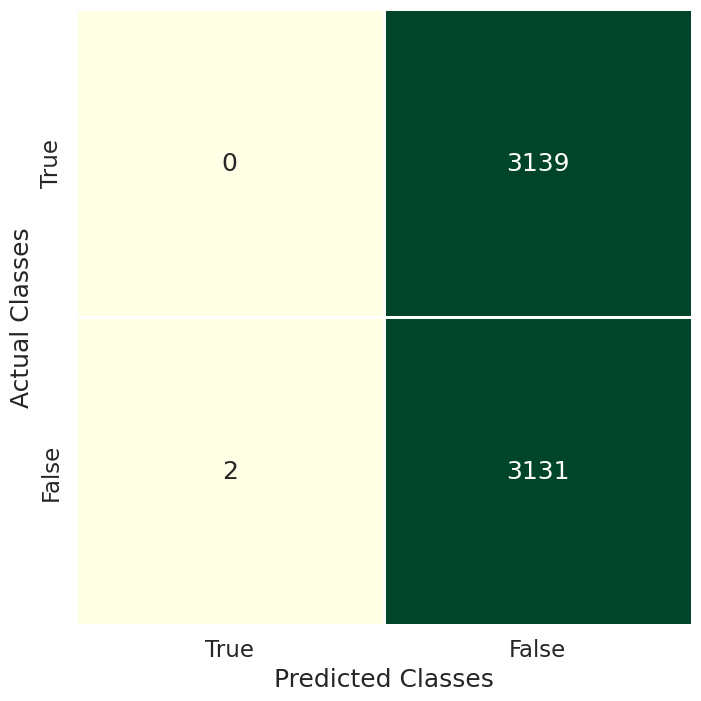

In [ ]:
confusion_mat('YlGn',y_test,pred)

In [ ]:
# @title Count vectorizer
test_vectors = count_vectorizer.transform(x_test)
pred = lr_model.predict(test_vectors)

In [ ]:
print('\nClassification Report\n')
print(classification_report(y_test,pred, digits=4))


Classification Report

              precision    recall  f1-score   support

           0     0.7478    0.1067    0.1868      3139
           1     0.5185    0.9639    0.6743      3133

    accuracy                         0.5349      6272
   macro avg     0.6332    0.5353    0.4306      6272
weighted avg     0.6333    0.5349    0.4303      6272



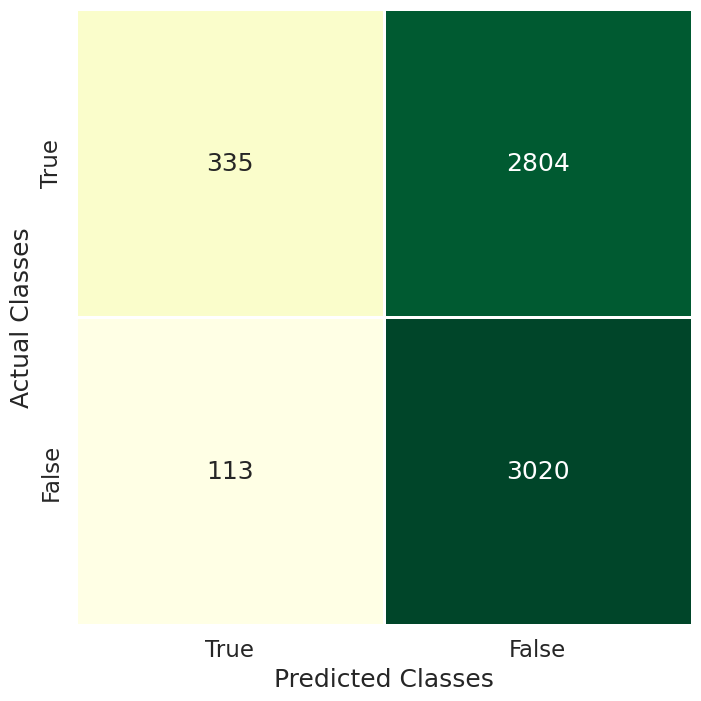

In [ ]:
confusion_mat('YlGn',y_test,pred)

In [ ]:
# @title BERT

X_test_token = tokenize(x_test)
y_pred = np.where(model.predict({ 'input_ids' : X_test_token['input_ids'] , 'input_mask' : X_test_token['attention_mask']}) >=0.5,1,0)

196/196 [==============================] - 45s 223ms/step


In [ ]:
print('\nClassification Report\n')
print(classification_report(y_test,y_pred, digits=4))


Classification Report

              precision    recall  f1-score   support

           0     0.8385    0.0347    0.0667      3139
           1     0.5067    0.9933    0.6711      3133

    accuracy                         0.5136      6272
   macro avg     0.6726    0.5140    0.3689      6272
weighted avg     0.6727    0.5136    0.3686      6272



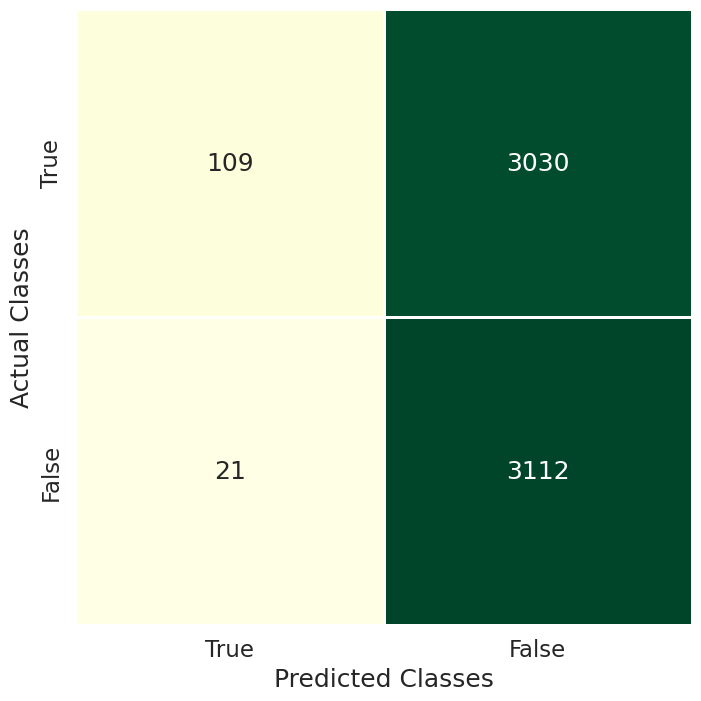

In [ ]:
confusion_mat('YlGn',y_test,y_pred)